# appflate

На проекте, где пользователь может отправить лайк другому пользователю, для увеличения количества лайков провели тест на замену сердца на галочку. При нажатии на крестик пользователю предлагается следующий пользователь. Тестовый вариант внедрили на пользователях с нечетным sender_id 24 марта в 16:00, на четных пользователях оставили базовый вариант.							


Вопрос
Нужно ли внедрить нововведение для всех или отклонить его?
Подкрепите выводы графиками


sender_id -уникальный идентификатор отправителя

platform_id - id платформы, 6 - декстоп, 7 - мобильная версия

time_stamp -Дата и время отправки

gender - Гендер отправителя

reg_date Дата регистрации пользователя

In [623]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from collections import Counter
from pathlib import Path
import sys

PATH = '/Users/danil/Documents/github/appflame'
sys.path.append(str(PATH))

In [624]:
df = pd.read_csv(PATH + '/data/raw/Test_4.csv', sep = ';')

print(df.shape)
df.head()

(768439, 5)


,sender_id,platform_id,time_stamp,gender,reg_date
0,3207526951,6,16.03.2017 13:35,m,26.01.2017
1,3207526951,6,16.03.2017 9:09,m,26.01.2017
2,3207526951,6,16.03.2017 9:09,m,26.01.2017
3,3207526951,6,16.03.2017 12:13,m,26.01.2017
4,3207526951,6,15.03.2017 14:01,m,26.01.2017


посмотрим на соотношения отправленных лайков в зависимости от катагорий 

In [625]:
df['platform_id'].value_counts()/df.shape[0]

6    0.580517
7    0.419483
Name: platform_id, dtype: float64

In [626]:
df['gender'].value_counts()/df.shape[0]

m    0.858323
f    0.141454
     0.000223
Name: gender, dtype: float64

In [641]:
df['reg_date'] = pd.to_datetime(df['reg_date'])
df['time_stamp'] = pd.to_datetime(df['time_stamp'])

In [642]:
print('min:', df['reg_date'].min(), 'max:', df['reg_date'].max())

min: 2017-01-01 00:00:00 max: 2017-12-03 00:00:00


очень жалко что нет пользователей которые зарегестрировались после начала теста, тк нужно тоже смотреть на активность пользователей которые не видели старый дизайн и "не предвзяты"

In [643]:
print('min:', df['time_stamp'].min(), 'max:', df['time_stamp'].max())

min: 2017-03-13 00:00:00 max: 2017-03-27 00:00:00


добавим колонку пренадлежания к группе

In [646]:
def is_odd(x: int) -> int:
    '''
    check if number is odd and return - 1, otherwise - 0
    '''
    
    if x % 2 == 0:
        res = 0
    else:
        res = 1
    return res

In [647]:
df['test_group'] = df['sender_id'].apply(is_odd)

для более удобного сравнения я сдвину все 'time_stamp' на 16 часов, чтобы начало теста приходилось на 24 марта

In [648]:
df_16h = df.copy()

df_16h['time_stamp'] = df_16h['time_stamp'] - pd.Timedelta(hours=16)
df_16h['date'] = df_16h['time_stamp'].dt.date

посмотрим на график лайков подневно

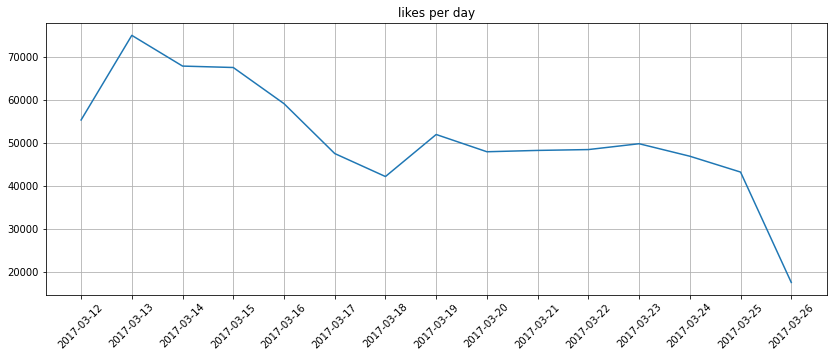

In [650]:
likes_per_day = df_16h['date'].value_counts().sort_index()[:]

likes_per_day.plot(figsize=(14,5), grid = True, xticks=likes_per_day.index).set_title('likes per day');
plt.xticks(rotation=45);

в последний день очень маленькие значения из-за моего сдвига 'time_stemp' и там данных только за 8 часов

посмотрим на количество уникальных пользователей по дням

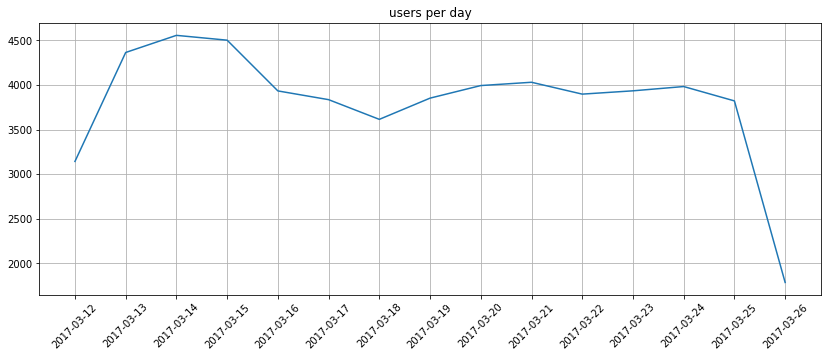

In [651]:
users_per_day = df_16h[['sender_id', 'date']].drop_duplicates()['date'].value_counts()[:]

users_per_day.plot(figsize=(14,5), grid = True, xticks=users_per_day.index).set_title('users per day');
plt.xticks(rotation=45);

но я считаю что лучше всего смотреть на график среднего количества лайков на пользователя 

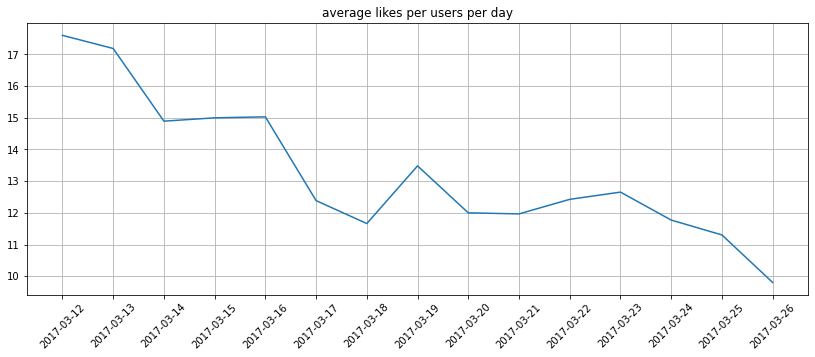

In [652]:
user_likes_per_day = likes_per_day / users_per_day

user_likes_per_day.plot(figsize=(14,5), grid = True, xticks=user_likes_per_day.index).set_title('average likes per users per day');
plt.xticks(rotation=45);

как вижно на всех графиках идеи небольшое падение активности, поэтому сразу выделить то что новый дизайн ухудшил ситуацию нельзя

посмотрим на активность в группах отдельно

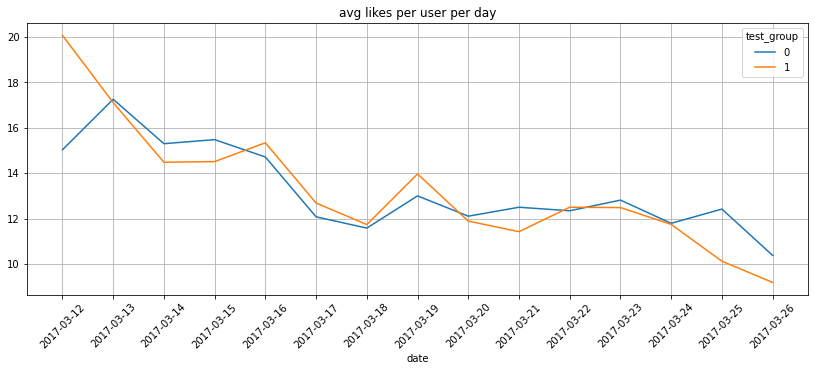

In [655]:
df_likes_per_day_per_group = df_16h.groupby(['date', 'test_group'])['test_group'].count().reset_index(name="count")
df_users_per_day_per_group = df_16h.groupby(['date', 'test_group'])['sender_id'].nunique().reset_index(name="count")
df_likes_per_day_per_group['likes_per_users'] = df_likes_per_day_per_group['count'] / df_users_per_day_per_group['count']

df_plot = df_likes_per_day_per_group.pivot(index='date', columns='test_group', values='likes_per_users')
df_plot.plot(figsize = (14, 5), grid = True, xticks=df_plot.index).set_title('avg likes per user per day');
plt.xticks(rotation=45);

и я считаю что нужно оценивать на сколько поведение в этих группах сильно отличается, тоесть смотреть на разницу этих графиков

In [656]:
diff = df_plot[0] - df_plot[1]
diff[:-3]

date
2017-03-12   -5.039401
2017-03-13    0.148098
2017-03-14    0.817314
2017-03-15    0.967356
2017-03-16   -0.625740
2017-03-17   -0.608493
2017-03-18   -0.154080
2017-03-19   -0.966492
2017-03-20    0.215338
2017-03-21    1.076998
2017-03-22   -0.157037
2017-03-23    0.329799
dtype: float64

с датой 2017-03-12 видно что то не так, очень большая разница, а на предыдущих графиках видно что в этот день было как то сильно мало пользователей и лайков, поэтому я не буду дальше учитывать этот день.

In [657]:
df_16h = df_16h[df_16h['date'] != datetime.date(2017, 3, 12)]

чтобы понять что разница между группами начинает сильно отличатся, я построю интервал в котором будет лежать 99.7% значений из этого распределения

In [658]:
mean = diff.values[1:-3].mean()
std = diff.values[1:-3].std()

In [659]:
n_sigma = 3
print('99.7% confidence interval (CI) for difference in groups:', [mean - n_sigma * std, mean + n_sigma * std])
print('difference after A/B test start:\n', diff[-3:])

99.7% confidence interval (CI) for difference in groups: [-1.8422717573537073, 2.0319192340819896]
difference after A/B test start:
 date
2017-03-24    0.047348
2017-03-25    2.296297
2017-03-26    1.191058
dtype: float64


видно что 2017-03-25 разница выходит за границы полученного интервала, она больше правой границы, что говорит о том что эта разница не типична для пользователей и можем сказать что на новым дизайном меньше пользователей воспользовалось, но потом 2017-03-26 уже разница вернулась в границы. В такой ситуации я бы продолжил тест

# gender analysis

male

In [664]:
df_analysis = df_16h[df_16h['gender'] == 'm']

group_balance = Counter(map(is_odd, df_analysis['sender_id'].unique()))
group_balance

Counter({1: 9458, 0: 9554})

Counter будет показывать сколько пользователей к какой группе пренадлежит

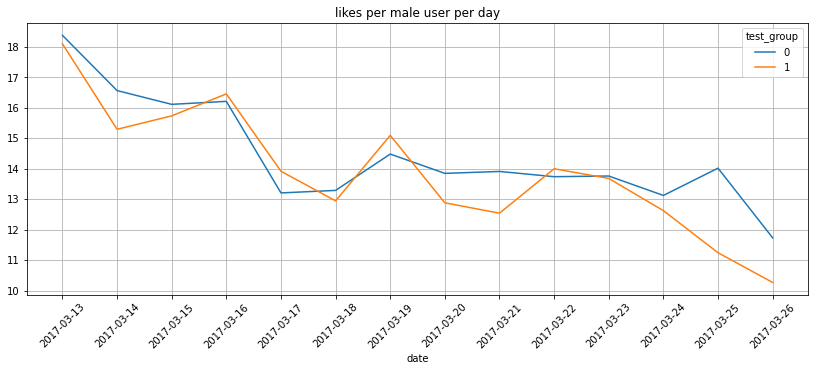

In [665]:
df_likes_per_day_per_group = df_analysis.groupby(['date', 'test_group'])['test_group'].count().reset_index(name="count")
df_users_per_day_per_group = df_analysis.groupby(['date', 'test_group'])['sender_id'].nunique().reset_index(name="count")
df_likes_per_day_per_group['likes_per_users'] = df_likes_per_day_per_group['count'] / df_users_per_day_per_group['count']

df_plot = df_likes_per_day_per_group.pivot(index='date', columns='test_group', values='likes_per_users')
df_plot.plot(figsize = (14, 5), grid = True, xticks=df_plot.index).set_title('likes per male user per day');
plt.xticks(rotation=45);

In [666]:
diff = df_plot[0] - df_plot[1]

mean = diff.values[:-3].mean()
std = diff.values[:-3].std()

In [667]:
n_sigma = 3
print('99.7% confidence interval (CI) for difference in groups:', [mean - n_sigma * std, mean + n_sigma * std])
print('difference after A/B test start:\n', diff[-3:])

99.7% confidence interval (CI) for difference in groups: [-1.7718260411262872, 2.2913805102484455]
difference after A/B test start:
 date
2017-03-24    0.499230
2017-03-25    2.777547
2017-03-26    1.465646
dtype: float64


тут видна такая же ситуация, 2017-03-25 - аномально большое раличие в поведении пользователей

female

In [668]:
df_analysis = df_16h[df_16h['gender'] == 'f']

group_balance = Counter(map(is_odd, df_analysis['sender_id'].unique()))
group_balance

Counter({0: 3204, 1: 3031})

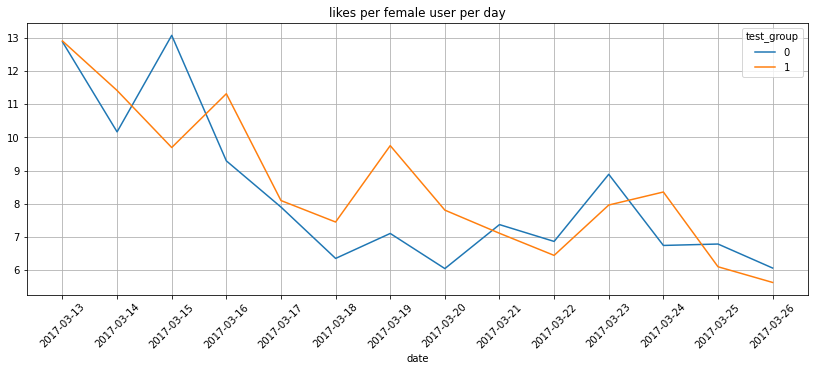

In [669]:
df_likes_per_day_per_group = df_analysis.groupby(['date', 'test_group'])['test_group'].count().reset_index(name="count")
df_users_per_day_per_group = df_analysis.groupby(['date', 'test_group'])['sender_id'].nunique().reset_index(name="count")
df_likes_per_day_per_group['likes_per_users'] = df_likes_per_day_per_group['count'] / df_users_per_day_per_group['count']

df_plot = df_likes_per_day_per_group.pivot(index='date', columns='test_group', values='likes_per_users')
df_plot.plot(figsize = (14, 5), grid = True, xticks=df_plot.index).set_title('likes per female user per day');
plt.xticks(rotation=45);

In [670]:
diff = df_plot[0] - df_plot[1]

mean = diff.values[:-3].mean()
std = diff.values[:-3].std()

In [671]:
n_sigma = 3
print('99.7% confidence interval (CI) for difference in groups:', [mean - n_sigma * std, mean + n_sigma * std])
print('difference after A/B test start:\n', diff[-3:])

99.7% confidence interval (CI) for difference in groups: [-5.167388084749531, 4.436821049406015]
difference after A/B test start:
 date
2017-03-24   -1.614015
2017-03-25    0.686265
2017-03-26    0.434795
dtype: float64


для female разница в поведении лежит в обычных рамках

# platform analysis

mobile

In [672]:
df_analysis = df_16h[df_16h['platform_id'] == 7]

group_balance = Counter(map(is_odd, df_analysis['sender_id'].unique()))
group_balance

Counter({1: 6963, 0: 7056})

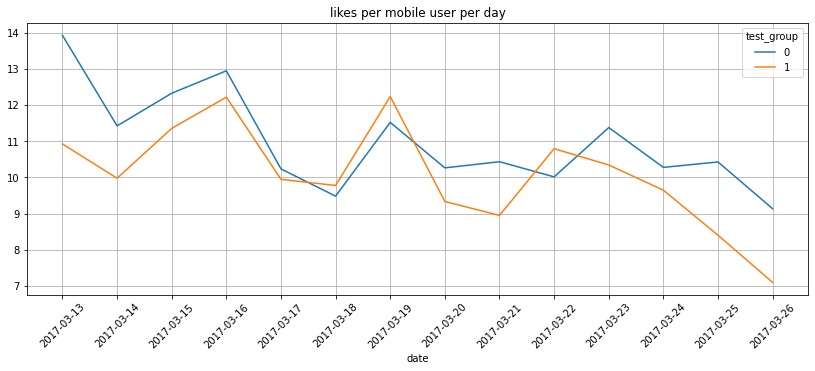

In [673]:
df_likes_per_day_per_group = df_analysis.groupby(['date', 'test_group'])['test_group'].count().reset_index(name="count")
df_users_per_day_per_group = df_analysis.groupby(['date', 'test_group'])['sender_id'].nunique().reset_index(name="count")
df_likes_per_day_per_group['likes_per_users'] = df_likes_per_day_per_group['count'] / df_users_per_day_per_group['count']

df_plot = df_likes_per_day_per_group.pivot(index='date', columns='test_group', values='likes_per_users')
df_plot.plot(figsize = (14, 5), grid = True, xticks=df_plot.index).set_title('likes per mobile user per day');
plt.xticks(rotation=45);

In [674]:
diff = df_plot[0] - df_plot[1]

mean = diff.values[:-3].mean()
std = diff.values[:-3].std()

In [675]:
n_sigma = 3
print('99.7% confidence interval (CI) for difference in groups:', [mean - n_sigma * std, mean + n_sigma * std])
print('difference after A/B test start:\n', diff[-3:])

99.7% confidence interval (CI) for difference in groups: [-2.407968369946437, 3.8840978716278918]
difference after A/B test start:
 date
2017-03-24    0.631987
2017-03-25    2.030064
2017-03-26    2.042596
dtype: float64


для mobile users разница в поведении лежит в обычных рамках

desctop

In [676]:
df_analysis = df_16h[df_16h['platform_id'] == 6]

group_balance = Counter(map(is_odd, df_analysis['sender_id'].unique()))
group_balance

Counter({1: 5797, 0: 5957})

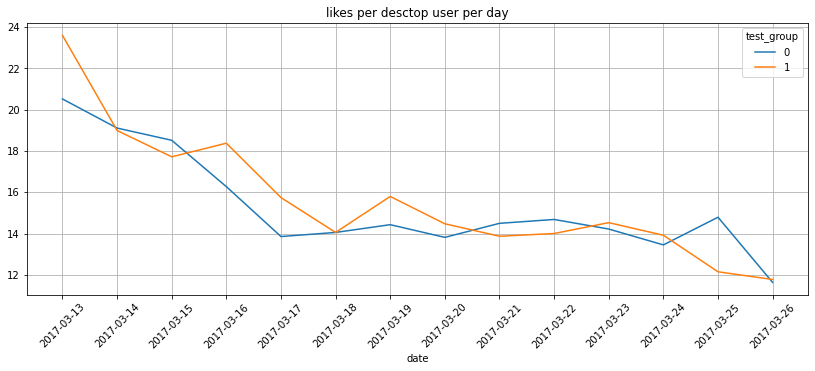

In [677]:
df_likes_per_day_per_group = df_analysis.groupby(['date', 'test_group'])['test_group'].count().reset_index(name="count")
df_users_per_day_per_group = df_analysis.groupby(['date', 'test_group'])['sender_id'].nunique().reset_index(name="count")
df_likes_per_day_per_group['likes_per_users'] = df_likes_per_day_per_group['count'] / df_users_per_day_per_group['count']

df_plot = df_likes_per_day_per_group.pivot(index='date', columns='test_group', values='likes_per_users')
df_plot.plot(figsize = (14, 5), grid = True, xticks=df_plot.index).set_title('likes per desctop user per day');
plt.xticks(rotation=45);

In [678]:
diff = df_plot[0] - df_plot[1]

mean = diff.values[:-3].mean()
std = diff.values[:-3].std()

In [679]:
n_sigma = 3
print('99.7% confidence interval (CI) for difference in groups:', [mean - n_sigma * std, mean + n_sigma * std])
print('difference after A/B test start:\n', diff[-3:])

99.7% confidence interval (CI) for difference in groups: [-4.351369013697962, 3.044628577358452]
difference after A/B test start:
 date
2017-03-24   -0.468247
2017-03-25    2.644030
2017-03-26   -0.144055
dtype: float64


для desctop users разница в поведении лежит в обычных рамках

Следующие шаги

1. было бы круто сравнить поведение пользователей которые зарегестрировались после начала теста
2. посмотреть на результаты теста в следующие дни
3. использовать CTR для подсчетов, тоесть было бы очень полезно знать, что пользователь просто увидел блок, а не только то что он на него нажал
4. разбить пользователей на 5 бинов по активности (к примеру кто ставит < 10 лайков за день(лучше сессию), ... и > 100) и сравнить изменения их активности. побинить основываясь на гистограмме среднего количества лайков в день(сессию)